<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Backpropagation Practice

## *Data Science Unit 4 Sprint 2 Assignment 2*

Implement a 3 input, 4 node hidden-layer, 1 output node Multilayer Perceptron on the following dataset:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 0  | 0  | 1  | 0 |
| 0  | 1  | 1  | 1 |
| 1  | 0  | 1  | 1 |
| 0  | 1  | 0  | 1 |
| 1  | 0  | 0  | 1 |
| 1  | 1  | 1  | 0 |
| 0  | 0  | 0  | 0 |

If you look at the data you'll notice that the first two columns behave like an XOR gate while the last column is mostly just noise. Remember that creating an XOR gate was what the perceptron was criticized for not being able to learn. 

In [5]:
# Load Data
import numpy as np


X = np.array((
    [0, 0, 1],
    [0, 1, 1],
    [1, 0, 1],
    [0, 1, 0],
    [1, 0, 0],
    [1, 1, 1],
    [0, 0, 0]
))

y = np.array((
    [0], [1], [1], [1], [1], [0], [0]
))

display(X, y)

array([[0, 0, 1],
       [0, 1, 1],
       [1, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [1, 1, 1],
       [0, 0, 0]])

array([[0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0]])

In [6]:
# Test given network class
nn = NeuralNetwork()

# Number of Epochs / Iterations
for i in range(10000):
    if (i+1 in [1,2,3,4,5]) or ((i+1) % 1000 ==0):
        print('+' + '---' * 3 + f'EPOCH {i+1}' + '---'*3 + '+')
        print('Input: \n', X)
        print('Actual Output: \n', y)
        print('Predicted Output: \n', str(nn.feed_forward(X)))
        print("Loss: \n", str(np.mean(np.square(y - nn.feed_forward(X)))))
    nn.train(X,y)


NameError: name 'NeuralNetwork' is not defined

In [8]:
def gen_random_matrix(shape):
    return np.random.rand(shape[0], shape[1])

# A lot of thought needs to go setting up the nodes.  Creating their size programatically
#  makes a lot of assumptions about hidden layer size (could be random, arbitrary, etc.).
#  One option would be to add a 'auto' feature that created hidden layers of X.shape + C
#  weights. Another would be to create pass a distribution and have the layer be a generator 
#  of sorts whose parameters can be optimized.

example_network_description = (
    ('input', X),  # row 0 must be input
    ('hidden_1', (X.shape[1], 3), 'simple random'),  # hidden vectors must match input vec
    ('hidden_2', (3, 7), 'simple random'),
    ('output', (7,1), 'simple random'),  # final active row must be output vector. match last hidden vec
    ('target', y) # last row in description must be the target vector
)


class LayerFactory():
    def __init__(self):
        return
    
    def initialize_weights(self, shape, algorithm):
        """
        Lookup available weight formulas and generate pseudo-random numbers for initial weights
        of specified shape.
        
        """
        available_generators = {
            'simple random': gen_random_matrix,
        }
        
        return available_generators[algorithm](shape)
    
    def generate_layers(self, description):
        """
        Generate layers based on network description.
        
        ====Parameters====
        description: tuple or list object of layer descriptions ('name', shape)
        """
        layers = {}
        layers[0] = Layer()
        layers[0].activated_values = description[0][1]
        for count, row in enumerate(description):
            if row[0] == 'target':
                layers[count] = Layer()
                layers[count].activated_values = description[len(description)-1][1]
                
            elif row[0] != 'input':
                layers[count] = Layer()
                layers[count].weights = self.initialize_weights(shape=row[1], algorithm=row[2])
                layers[count].weighted_sum = 0
                layers[count].activated_values = 0
            
        
        return layers
    
    
class Layer():
    pass
    

class NeuralNetwork(LayerFactory):
    def __init__(self, description):
        # Set up Architecture of Neural Network
        self.description = description
        self.layers = self.generate_layers(description)
        
    def sigmoid(self, weighted_sum):
        return 1 / (1+np.exp(-weighted_sum))
    
    def sigmoidPrime(self, weighted_sum):
        return weighted_sum * (1 - weighted_sum)
    
    def feed_forward(self, X):
        """
        Calculate the NN inference using feed forward.
        aka "predict"
        """
        for i in range(1, len(self.layers)-1):
            # Weighted sum of inputs
            #  Check if first layer (required to use feed_forward method as Predict)
            if i == 1:
                self.layers[i].weighted_sum = np.dot(X, self.layers[i].weights)
                # Activated values (local outputs)
                self.layers[i].activated_values = self.sigmoid(self.layers[i].weighted_sum)
            else:
                self.layers[i].weighted_sum = np.dot(self.layers[i-1].activated_values, self.layers[i].weights)
                # Activated values (local outputs)
                self.layers[i].activated_values = self.sigmoid(self.layers[i].weighted_sum)

        return self.layers[len(self.layers)-2].activated_values
        
    def backward(self, X, y, net_output, learning_rate):
        """
        Backward propagate through the network
        """
        # Step 1: Calculate errors and delta shifts for each layer (backward)
        back_prop_pos = 0
        for i in range(len(self.layers)-2, 0, -1):
            # Error in local output
            #   Check if first backprop
            if back_prop_pos == 0:
                self.layers[i].error = self.layers[i+1].activated_values - net_output
                # Apply Derivative of Sigmoid to error
                self.layers[i].delta = self.layers[i].error * self.sigmoidPrime(net_output)
            else:
                self.layers[i].error = self.layers[i+1].delta.dot(self.layers[i+1].weights.T)
                # Apply Derivative of Sigmoid to error
                self.layers[i].delta = self.layers[i].error * self.sigmoidPrime(
                    self.layers[i].activated_values)*learning_rate
                
            back_prop_pos += 1
            
        # Step 2: Calculate adjustments and apply to each layer (forward)
        for i in range(1, len(self.layers)-1):
            self.layers[i].weights += self.layers[i-1].activated_values.T.dot(self.layers[i].delta)
        
    def train(self, X, y, learning_rate):
        net_output = self.feed_forward(X)
        self.backward(X, y, net_output, learning_rate)

In [9]:
# Testing block.
for i in range(len(layers)-2, 0, -1):
    print(i)

NameError: name 'layers' is not defined

In [10]:
# Test LayerFactory
factory = LayerFactory()
layers = factory.generate_layers(description=example_network_description)
layers

{0: <__main__.Layer at 0x7f5a3cef6470>,
 1: <__main__.Layer at 0x7f5a3cef66d8>,
 2: <__main__.Layer at 0x7f5a3cef65c0>,
 3: <__main__.Layer at 0x7f5a3cef6c18>,
 4: <__main__.Layer at 0x7f5a3cef6630>}

In [11]:
layers[2].weights

array([[0.62710878, 0.95262447, 0.80739135, 0.37436599, 0.42188375,
        0.02954279, 0.76865005],
       [0.778027  , 0.51607266, 0.87361569, 0.35606138, 0.00713691,
        0.77170409, 0.34532938],
       [0.10597956, 0.44483607, 0.55169943, 0.90002817, 0.33284319,
        0.26650898, 0.40674867]])

In [12]:
# Ensure layers being created correctly in NN
nn = NeuralNetwork(description=example_network_description)
# Number of Epochs / Iterations
for i in range(10000):
    if (i+1 in [1,2,3,4,5]) or ((i+1) % 1000 ==0):
        print('+' + '---' * 3 + f'EPOCH {i+1}' + '---'*3 + '+')
        print('Input: \n', X)
        print('Actual Output: \n', y)
        print('Predicted Output: \n', str(nn.feed_forward(X)))
        print("Loss: \n", str(np.mean(np.square(y - nn.feed_forward(X)))))
    nn.train(X,y,0.1)

+---------EPOCH 1---------+
Input: 
 [[0 0 1]
 [0 1 1]
 [1 0 1]
 [0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 0]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
 [[0.90001542]
 [0.90943558]
 [0.90684305]
 [0.8997136 ]
 [0.89520821]
 [0.91293224]
 [0.88283682]]
Loss: 
 0.35154181530121204
+---------EPOCH 2---------+
Input: 
 [[0 0 1]
 [0 1 1]
 [1 0 1]
 [0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 0]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
 [[0.77460858]
 [0.78528419]
 [0.78241465]
 [0.77425127]
 [0.76964302]
 [0.78951931]
 [0.75671251]]
Loss: 
 0.2847780148880342
+---------EPOCH 3---------+
Input: 
 [[0 0 1]
 [0 1 1]
 [1 0 1]
 [0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 0]]
Actual Output: 
 [[0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]]
Predicted Output: 
 [[0.52184464]
 [0.5233401 ]
 [0.52332309]
 [0.52171843]
 [0.52196283]
 [0.52432127]
 [0.52013619]]
Loss: 
 0.24706780520505797
+---------EPOCH 4---------+
Input: 
 [[0 0 1]
 [0 1 1]
 [1 0 1]
 [0 1 0]
 [1 0 0]
 [1 1 1]
 [0 0 0

In [128]:
nn.layers[1].weights

array([[0.57969291, 0.88623463, 0.82354341, 0.28966033, 0.25362587,
        0.90120771, 0.7845741 ],
       [0.67906782, 0.29905237, 0.27333864, 0.60150628, 0.25300745,
        0.6969853 , 0.02095351],
       [0.16736435, 0.54543392, 0.53045375, 0.86785617, 0.26756957,
        0.06520021, 0.35142303]])

### Building Flexible Perceptron Network

In [158]:
# SEE ABOVE!! WOOT!!

## Try building/training a more complex MLP on a bigger dataset.

Use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) to build the cannonical handwriting digit recognizer and see what kind of accuracy you can achieve. 

If you need inspiration, the internet is chalk-full of tutorials, but I want you to see how far you can get on your own first. I've linked to the original MNIST dataset above but it will probably be easier to download data through a neural network library. If you reference outside resources make sure you understand every line of code that you're using from other sources, and share with your fellow students helpful resources that you find.


### Parts
1. Gathering & Transforming the Data
2. Making MNIST a Binary Problem
3. Estimating your Neural Network (the part you focus on)

### Gathering the Data 

`keras` has a handy method to pull the mnist dataset for you. You'll notice that each observation is a 28x28 arrary which represents an image. Although most Neural Network frameworks can handle higher dimensional data, that is more overhead than necessary for us. We need to flatten the image to one long row which will be 784 values (28X28). Basically, you will be appending each row to one another to make on really long row. 

In [146]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [147]:
# input image dimensions
img_rows, img_cols = 28, 28

In [148]:
# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [149]:
X_train = X_train.reshape(X_train.shape[0], img_rows * img_cols)
X_test = X_test.reshape(x_test.shape[0], img_rows * img_cols)

# Normalize Our Data
X_train = X_train / 255
X_test = X_test / 255

In [150]:
# Now the data should be in a format you're more familiar with
x_train.shape

(60000, 784)

### Making MNIST a Binary Problem 
MNIST is multiclass classification problem; however we haven't covered all the necessary techniques to handle this yet. You would need to one-hot encode the target, use a different loss metric, and use softmax activations for the last layer. This is all stuff we'll cover later this week, but let us simply the problem for now: Zero or all else.

In [151]:
import numpy as np

y_temp = np.zeros(y_train.shape)
y_temp[np.where(y_train == 0.0)[0]] = 1
y_train = y_temp

y_temp = np.zeros(y_test.shape)
y_temp[np.where(y_test == 0.0)[0]] = 1
y_test = y_temp

In [152]:
# A Nice Binary target for ya to work with
y_train = y_train.reshape(-1,1)
y_train

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [161]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

### Balance the class

In [268]:
import pandas as pd

# concatenate the data
df_train = pd.DataFrame(X_train)
df_train['target'] = y_train
df_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [274]:
from sklearn.utils import resample
# try to get a balanced sample

# Separate majority/minority classes
df_majority = df_train[df_train.target == 0]
df_minority = df_train[df_train.target == 1]


# Downsample majority class
df_majority_downsampled = resample(
                                    df_majority,
                                    replace=False,
                                    n_samples=5923,
                                    random_state=42
                                  )

df_downsampled = pd.concat([
    df_majority_downsampled,
    df_minority
])

df_downsampled.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,target
count,11846.0,11846.0,11846.0,11846.0,11846.0,11846.0,11846.0,11846.0,11846.0,11846.0,...,11846.000000,11846.000000,11846.000000,11846.000000,11846.000000,11846.0,11846.0,11846.0,11846.0,11846.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000185,0.000030,0.000014,0.000081,0.000021,0.0,0.0,0.0,0.0,0.500000
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011510,0.003279,0.001549,0.008792,0.002234,0.0,0.0,0.0,0.0,0.500021
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.500000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.996078,0.356863,0.168627,0.956863,0.243137,0.0,0.0,0.0,0.0,1.000000


### Estimating Your  Net

In [283]:
##### Your Code Here #####

# Use balanced training set
X = df_downsampled.drop(columns='target')
y = df_downsampled.target.to_numpy().reshape(-1,1)

network_description = (
    ('input', X),  # row 0 must be input
    ('hidden_1', (X.shape[1], 768), 'simple random'),  # hidden vectors must match input vec
    ('hidden_2', (768, 50), 'simple random'),
    ('hidden_3', (50, 10), 'simple random'),
    ('output', (10,1), 'simple random'),  # final active row must be output vector. match last hidden vec
    ('target', y) # last row in description must be the target vector
)

In [284]:
display(X.shape, y.shape)

(11846, 784)

(11846, 1)

In [286]:
network = NeuralNetwork(description=network_description)
# Number of Epochs / Iterations
losses = []
for i in range(1000):
    if (i+1 in [1,2,3,4,5]) or ((i+1) % 100 ==0):
        print('+' + '---' * 3 + f'EPOCH {i+1}' + '---'*3 + '+')
        loss = np.mean(np.square(y - network.feed_forward(X)))
        losses.append(loss)
        print("Loss: \n", str(np.mean(np.square(y - network.feed_forward(X)))))
    network.train(X, y, 0.1)

+---------EPOCH 1---------+
Loss: 
 0.4796212892485052
+---------EPOCH 2---------+
Loss: 
 0.5
+---------EPOCH 3---------+
Loss: 
 0.5
+---------EPOCH 4---------+
Loss: 
 0.5
+---------EPOCH 5---------+
Loss: 
 0.5
+---------EPOCH 100---------+
Loss: 
 0.5
+---------EPOCH 200---------+
Loss: 
 0.5
+---------EPOCH 300---------+
Loss: 
 0.5
+---------EPOCH 400---------+
Loss: 
 0.5
+---------EPOCH 500---------+
Loss: 
 0.5
+---------EPOCH 600---------+
Loss: 
 0.5
+---------EPOCH 700---------+
Loss: 
 0.5
+---------EPOCH 800---------+
Loss: 
 0.5
+---------EPOCH 900---------+
Loss: 
 0.5
+---------EPOCH 1000---------+
Loss: 
 0.5


In [253]:
np.mean(network.layers[len(network.layers)-1].activated_values == y_train)

1.0

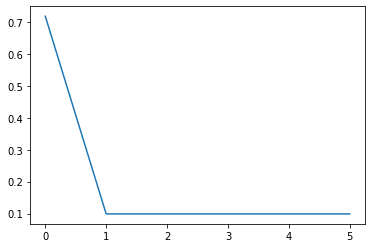

In [254]:
# Visualize losses
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show();

In [255]:
# Calculate on test set
np.mean(network.feed_forward(X_test) == y_test.reshape(-1,1))

0.902

In [259]:
# What is the majority class?
np.mean(y_train)

0.09871666666666666

In [ ]:
# It's probably guessing everything is a one.  Would yield similar efficiency.  Does not
#  Beat majority classifier.

## Stretch Goals: 

- Make MNIST a multiclass problem using cross entropy & soft-max
- Implement Cross Validation model evaluation on your MNIST implementation 
- Research different [Gradient Descent Based Optimizers](https://keras.io/optimizers/)
 - [Siraj Raval the evolution of gradient descent](https://www.youtube.com/watch?v=nhqo0u1a6fw)
- Build a housing price estimation model using a neural network. How does its accuracy compare with the regression models that we fit earlier on in class?